## Importing Dependencies

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report , precision_score , recall_score 
from sklearn.metrics import f1_score , roc_curve
from sklearn.metrics import auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_classification

In [2]:
engine =create_engine('sqlite:///../Data/2023_march.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [3]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2023-02-16,3.32,1.69,Utah,39.706944,-112.278967,5.732727,6.249333,6.334286,1.196818,1.238667,1.511429,0
1,2023-02-16,0.53,-0.26,Utah,39.706944,-112.278967,5.910455,5.754667,4.554286,1.113636,1.176667,1.265714,0
2,2023-02-16,5.01,0.36,Utah,39.706944,-112.278967,6.012273,5.925333,4.437143,1.062273,1.003333,1.075714,0
3,2023-02-17,5.37,0.91,Utah,39.706944,-112.278967,6.025000,5.922667,4.204286,1.134091,1.012000,1.044286,0
4,2023-02-17,7.09,0.90,Utah,39.706944,-112.278967,6.096364,6.022667,4.820000,1.115000,1.033333,1.007143,0


In [4]:
engine =create_engine('sqlite:///../Data/2023_march_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [5]:
df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2023-03-07,7.63,1.69,Utah,39.706944,-112.278967,4.565455,6.140000,7.581429,1.155000,1.145333,1.341429,NaN
1,2023-03-07,9.65,2.68,Utah,39.706944,-112.278967,4.993182,6.414000,6.020000,1.285909,1.256667,1.467143,NaN
2,2023-03-07,9.35,1.22,Utah,39.706944,-112.278967,5.418182,6.490000,5.697143,1.330909,1.213333,1.414286,NaN
3,2023-03-08,9.97,1.91,Utah,39.706944,-112.278967,5.881818,6.992667,7.527143,1.364091,1.332667,1.438571,NaN
4,2023-03-09,2.49,2.28,Utah,39.706944,-112.278967,6.145455,7.140000,6.588571,1.387273,1.444667,1.602857,NaN


In [6]:
df_features.corr()

,depth,mag,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
depth,1.000000,0.334814,0.125466,-0.061006,0.477961,0.497904,0.557688,0.163168,0.171044,0.190827,0.089121
mag,0.334814,1.000000,-0.235942,0.357574,0.213800,0.219993,0.232957,0.633687,0.647523,0.689136,0.469006
latitude,0.125466,-0.235942,1.000000,-0.681038,0.272215,0.263720,0.236421,-0.367385,-0.358623,-0.338296,-0.409236
longitude,-0.061006,0.357574,-0.681038,1.000000,-0.145480,-0.141656,-0.128700,0.551778,0.541521,0.512544,0.683211
depth_avg_22,0.477961,0.213800,0.272215,-0.145480,1.000000,0.961416,0.851406,0.340444,0.335936,0.315302,0.165030
depth_avg_15,0.497904,0.219993,0.263720,-0.141656,0.961416,1.000000,0.887835,0.325268,0.341026,0.323307,0.158822
depth_avg_7,0.557688,0.232957,0.236421,-0.128700,0.851406,0.887835,1.000000,0.283055,0.298654,0.339809,0.140222
mag_avg_22,0.163168,0.633687,-0.367385,0.551778,0.340444,0.325268,0.283055,1.000000,0.981060,0.920057,0.722123
mag_avg_15,0.171044,0.647523,-0.358623,0.541521,0.335936,0.341026,0.298654,0.981060,1.000000,0.942450,0.709919
mag_avg_7,0.190827,0.689136,-0.338296,0.512544,0.315302,0.323307,0.339809,0.920057,0.942450,1.000000,0.672386


In [7]:
features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

In [8]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

In [9]:
X=df_features[features]

In [10]:
X

,depth,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7
0,3.320,5.732727,6.249333,6.334286,1.196818,1.238667,1.511429
1,0.530,5.910455,5.754667,4.554286,1.113636,1.176667,1.265714
2,5.010,6.012273,5.925333,4.437143,1.062273,1.003333,1.075714
3,5.370,6.025000,5.922667,4.204286,1.134091,1.012000,1.044286
4,7.090,6.096364,6.022667,4.820000,1.115000,1.033333,1.007143
...,...,...,...,...,...,...,...
9474,88.951,54.526273,66.680800,33.159286,4.668182,4.566667,4.557143
9475,10.000,51.944682,66.680800,33.159286,4.690909,4.580000,4.600000
9476,130.569,57.425091,74.718733,50.383429,4.677273,4.573333,4.557143
9477,49.905,59.238955,39.177467,52.215000,4.686364,4.620000,4.542857


In [11]:
y=df_features["mag_outcome"]

In [12]:
y

0       0
1       0
2       0
3       0
4       0
       ..
9474    1
9475    1
9476    1
9477    1
9478    1
Name: mag_outcome, Length: 9479, dtype: int64

In [13]:
y_df=pd.DataFrame(y)

## Train Test Split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)


Models used for training:

- Adaboost classifier with DecisionTree
- Adaboost classifier with RandomForest
- GridSearch CV for hyper parameter tunning

Model for deployment/testing:

- XgBoost with Hyperparameters set from above models


## AdaBoost 

#### AdaBoost + Decsion Tree Classifier

In [15]:
param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

In [16]:
# base estimator
tree = DecisionTreeClassifier()

In [17]:
# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [18]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [19]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [20]:
pred_ABC=grid_search_ABC.predict(X_test)

In [21]:
print("Train Accuracy:",grid_search_ABC.score(X_train, y_train)*100,"%")
print("Test Accuracy:",grid_search_ABC.score(X_test, y_test)*100,"%")
print("Precision Score: ",precision_score(y_test, pred_ABC))
print("Recall Score: ",recall_score(y_test, pred_ABC)) 
print("F1 Score: ",f1_score(y_test, pred_ABC))

Train Accuracy: 99.9546875 %
Test Accuracy: 99.14833372865274 %
Precision Score:  0.944954128440367
Recall Score:  0.8306451612903226
F1 Score:  0.8841201716738197


In [22]:
print("Confusion Matrix: ")
cm_abc=confusion_matrix(y_test, pred_ABC)
print(cm_abc)

Confusion Matrix: 
[[2714    6]
 [  21  103]]


AUC: 0.9142


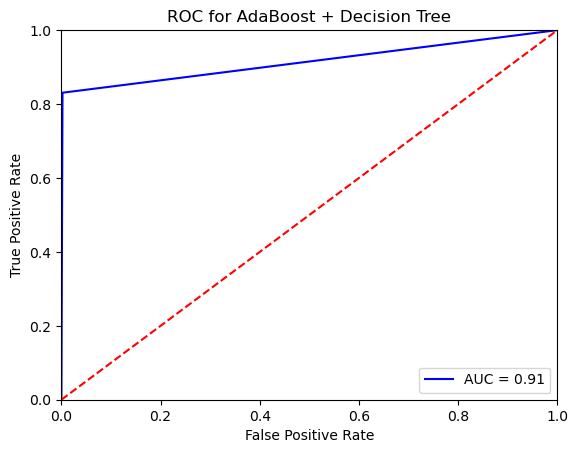

In [23]:
fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('ROC for AdaBoost + Decision Tree')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### AdaBoost with Random Forest Classifier

In [24]:
rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

In [25]:
param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [26]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [27]:
pred=CV_rfc.predict(X_test)

In [28]:
print("Train Accuracy:",CV_rfc.score(X_train, y_train)*100,"%")
print("Test Accuracy:",CV_rfc.score(X_test, y_test)*100,"%")
print("Precision Score: ",precision_score(y_test, pred))
print("Recall Score: ",recall_score(y_test, pred)) 
print("F1 Score: ",f1_score(y_test, pred))

Train Accuracy: 100.0 %
Test Accuracy: 99.19127988748242 %
Precision Score:  0.9719626168224299
Recall Score:  0.8387096774193549
F1 Score:  0.9004329004329005


In [29]:
print("Confusion Matrix: ")
cm_abc_rf=confusion_matrix(y_test, pred)
print(cm_abc_rf)

Confusion Matrix: 
[[2717    3]
 [  20  104]]


AUC: 0.9188


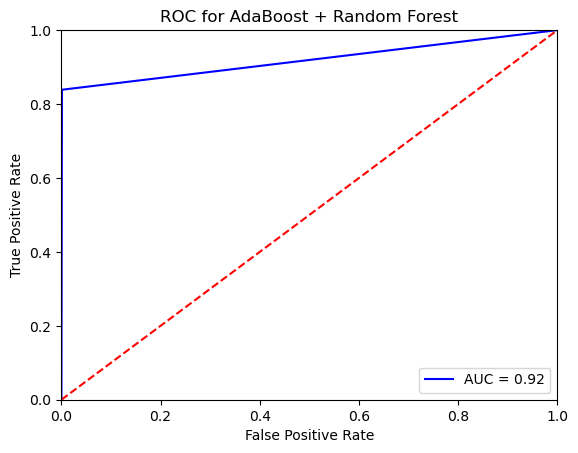

In [30]:
fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))
plt.title('ROC for AdaBoost + Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## XgBoost

In [45]:
import xgboost as xgb

In [53]:
model_xg = xgb.XGBClassifier()

model_xg.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [54]:
y_pred_xg = model_xg.predict(X_test)

In [55]:
print (roc_auc_score(y_test, y_pred_xg))
fpr, tpr, _ = roc_curve(y_test, y_pred_xg)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

0.9272355313092979
AUC: 0.9272


In [56]:
print('Results obtained for XG Boost\n')


print("Train Accuracy:",model_xg.score(X_train, y_train)*100,"%")
xg_acc=model_xg.score(X_test, y_test)*100
print("Test Accuracy:",xg_acc,"%")
print("Precision Score: ",precision_score(y_test, y_pred_xg,average="micro"))
print("Recall Score: ",recall_score(y_test, y_pred_xg,average="micro")) 
print("F1 Score: ",f1_score(y_test, y_pred_xg,average="micro"))
# print("ROC AUC Score: ",roc_auc_score(y, model_xg.predict_proba(X)[:, 1]))

print("\n\nConfusion Matrix: ")
cm_xg=confusion_matrix(y_test, y_pred_xg)
print(cm_xg)

Results obtained for XG Boost

Train Accuracy: 99.98492840994724 %
Test Accuracy: 99.33192686357243 %
Precision Score:  0.9933192686357243
Recall Score:  0.9933192686357243
F1 Score:  0.9933192686357243


Confusion Matrix: 
[[2719    1]
 [  18  106]]


In [63]:
from sklearn.model_selection import GridSearchCV

param = {
        'objective': ['binary:logistic'],
        'booster': ['gbtree'],
        'eval_metric': ['auc'],
        'max_depth': [6],  # the maximum depth of each tree
        'eta': [0.003],  # the training step for each iteration
        'silent': [1]}

In [64]:
grid_search_xg = GridSearchCV(model_xg, param_grid=param, cv=5)
grid_search_xg.fit(X_train, y_train)

[01:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[01:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[01:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[01:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[01:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.

[01:00:04] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                   

In [65]:
accuracy = grid_search_xg.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searched pipeline is: "
    f"{accuracy:.2f}"
)

The test accuracy score of the grid-searched pipeline is: 0.99


In [68]:
print (roc_auc_score(y_test, pred_xg))

0.8986420777988615


In [67]:
pred_xg=grid_search_xg.predict(X_test)

In [33]:
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

[19:30:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "silent" } are not used.



In [34]:
print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

0.9927478652751424
AUC: 0.9927


In [35]:
ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int) 

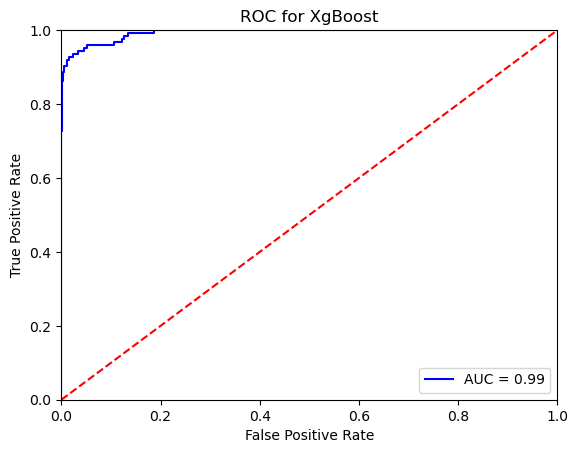

In [36]:
plt.title('ROC for XgBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [37]:
print("Confusion Matrix: \n",confusion_matrix(y_test,ypred_bst))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

Confusion Matrix: 
 [[2718    2]
 [  20  104]]

Recall 'TP/TP+FN' =  0.8387096774193549


### Prediction on df_predict data frame

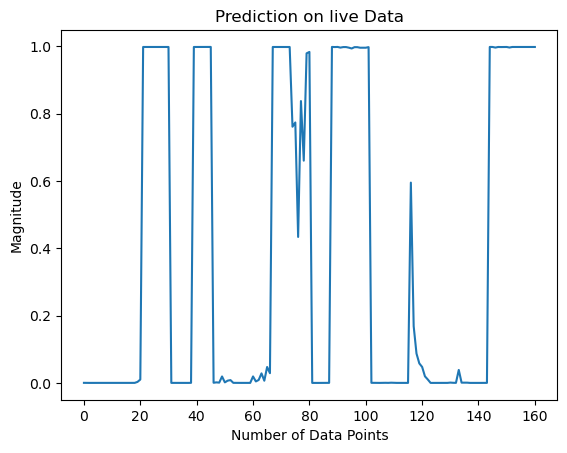

In [38]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.title("Prediction on live Data")
plt.ylabel("Magnitude")
plt.xlabel("Number of Data Points")
plt.plot(preds)
plt.show()

## Prediction

In [39]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

,date,place,latitude,longitude,quake
68,2023-03-18,Philippines,9.823771,124.523266,0.997920
69,2023-03-18,Puerto Rico,18.260614,-66.665198,0.778681
70,2023-03-18,Texas,31.888183,-102.961827,0.010316
71,2023-03-18,Turkey,37.709543,37.263933,0.997510
72,2023-03-18,Washington,46.965348,-121.890363,0.000191


In [40]:
import datetime as dt
# convert date to proper format for prediction
days = list(set([d for d in live_set['date'].astype(str)]))
days.sort()

In [41]:
days

['2023-03-07',
 '2023-03-09',
 '2023-03-10',
 '2023-03-11',
 '2023-03-12',
 '2023-03-13',
 '2023-03-14',
 '2023-03-15',
 '2023-03-16',
 '2023-03-17',
 '2023-03-18']

In [42]:
# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[2]
predict_day

'2023-03-10'

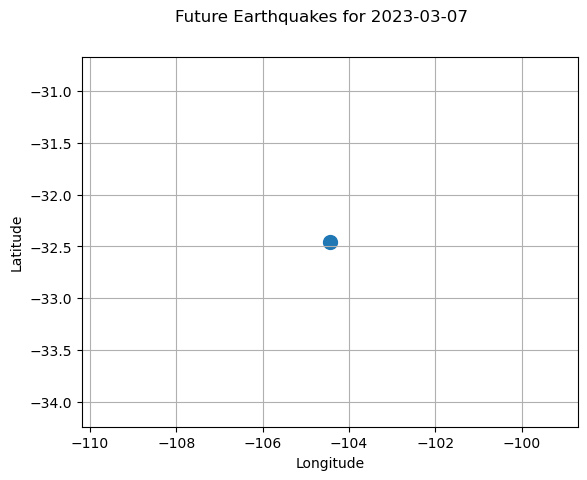

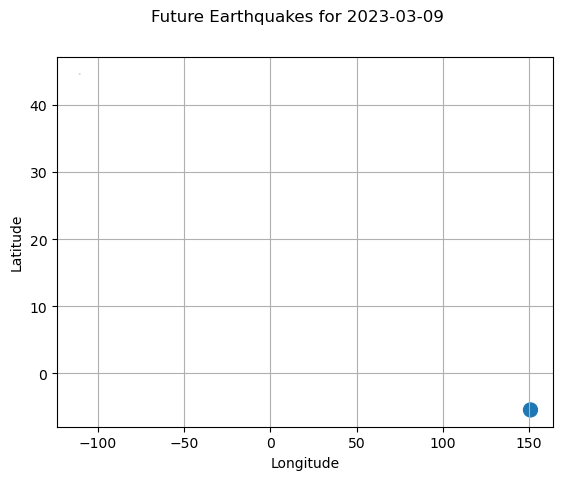

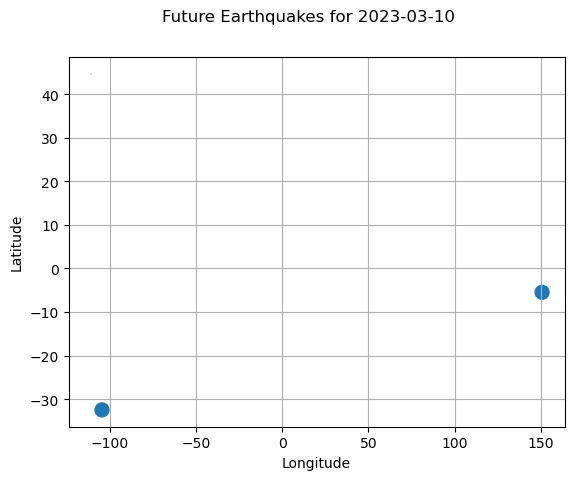

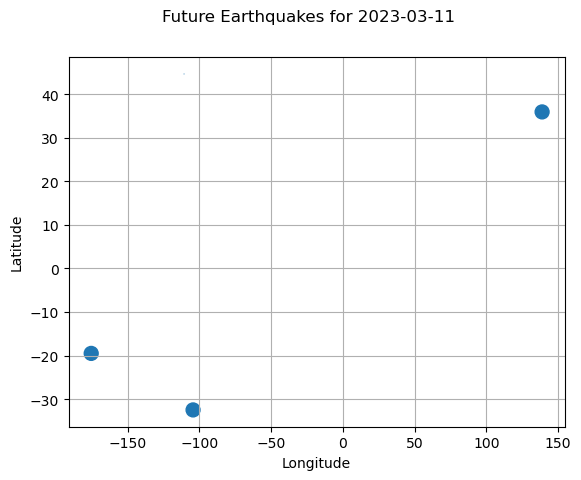

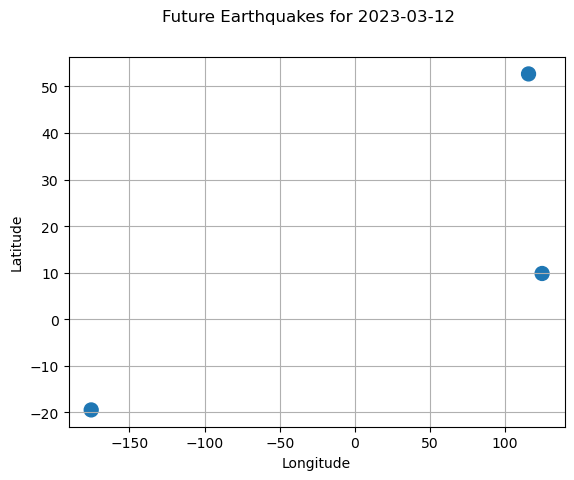

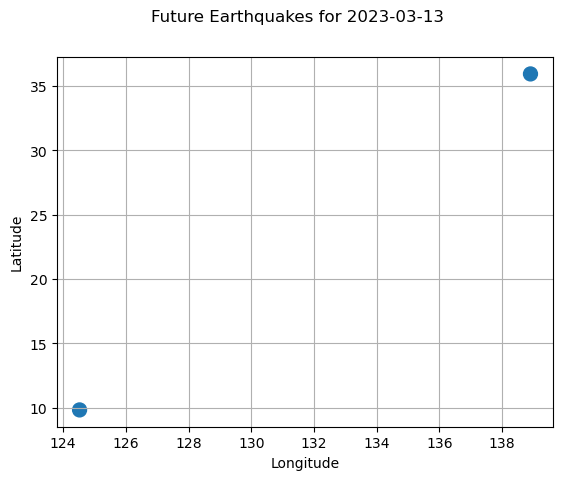

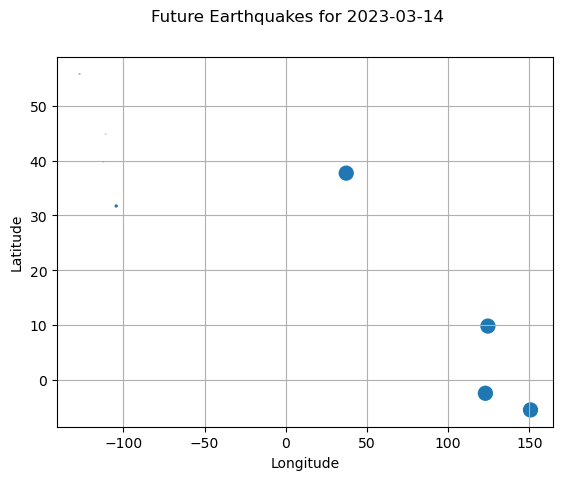

In [43]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()
    plt.show()